In [1]:
import sys,os,os.path
#sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/gluster/data/next/software/IC_satkill/")
#sys.path.append("/gluster/data/next/software/IC_sophronia/")
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/gluster/data/next/software/IC_satkill/'


#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import time

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs
from matplotlib.lines import Line2D


import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits, drop_end_point_voxels, make_track_graphs, get_track_energy

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize



def threshold_hits(threshold_charge, same_peak, hitc):
    """
    Applies a threshold to hits and redistributes the charge/energy.

    Parameters
    ----------
    threshold_charge : float
        minimum pes of a hit
    same_peak        : bool
        whether to reassign NN hits' energy only to the hits from the same peak

    Returns
    ----------
    A function that takes HitCollection as input and returns another object with
    only non NN hits of charge above threshold_charge.
    The energy of NN hits is redistributed among neighbors.
    """

    t = hitc.time
    thr_hits = hif.threshold_hits(hitc.hits, threshold_charge     )
    mrg_hits = hif.merge_NN_hits ( thr_hits, same_peak = same_peak)

    cor_hits = []
    for hit in mrg_hits:
        cluster = Cluster(hit.Q, xy(hit.X, hit.Y), hit.var, hit.nsipm)
        xypos   = xy(hit.Xpeak, hit.Ypeak)
        hit     = Hit(hit.npeak, cluster, hit.Z, hit.E, xypos, hit.Ec)
        cor_hits.append(hit)

    new_hitc      = HitCollection(hitc.event, t)
    new_hitc.hits = cor_hits
    return new_hitc





def hits_from_df (dst, skip_NN = False):
    """
    Function that transforms pandas DataFrame dst to HitCollection
    ------
    Parameters
    ------
    dst : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
        If time, nsipm, Xrms, Yrms, Qc, Ec, track_id are not
        inside dst the default value is set to -1
        If Xpeak, Ypeak not in dst the default value is -1000
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    https://github.com/next-exp/IC/blob/v2-development/invisible_cities/io/hits_io.py#L16
    """
    all_events = {}
    times = getattr(dst, 'time', [-1]*len(dst))
    for (event, time) , df in dst.groupby(['event', times]):
        #pandas is not consistent with numpy dtypes so we have to change it by hand
        event = np.int32(event)
        hits  = []
        for i, row in df.iterrows():
            Q = getattr(row,'Q', row.E)
            if skip_NN and Q == NN:
                continue
            if hasattr(row, 'Xrms'):
                Xrms  = row.Xrms
                Xrms2 = Xrms**2
            else:
                Xrms = Xrms2 = -1
            if hasattr(row, 'Yrms'):
                Yrms  = row.Yrms
                Yrms2 = Yrms**2
            else:
                Yrms = Yrms2 = -1
            nsipm   = getattr(row, 'nsipm'   , -1   )     # for backwards compatibility
            Qc      = getattr(row, 'Qc'      , -1   )     # for backwards compatibility
            Xpeak   = getattr(row, 'Xpeak'   , -1000)     # for backwards compatibility
            Ypeak   = getattr(row, 'Ypeak'   , -1000)     # for backwards compatibility
            Ec      = getattr(row, 'Ec'      , -1   )     # for backwards compatibility
            trackID = getattr(row, 'track_id', -1   )     # for backwards compatibility
            Ep      = getattr(row, "Ep"      , -1   )     # for backwards compatibility

            hit = Hit(row.npeak            ,
                      Cluster(Q               ,
                              xy(row.X, row.Y),
                              xy(Xrms2, Yrms2),
                              nsipm = nsipm   ,
                              z     = row.Z   ,
                              E     = row.E   ,
                              Qc    = Qc      ),
                      row.Z                ,
                      row.E                ,
                      xy(Xpeak, Ypeak)     ,
                      s2_energy_c = Ec     ,
                      track_id    = trackID,
                      Ep          = Ep     )

            hits.append(hit)

        if len(hits):
            all_events[event] = HitCollection(event, time, hits=hits)

    return all_events

def hitc_to_df_(hitc):
    columns = defaultdict(list)
    for hit in hitc.hits:
        columns["event"   ].append(hitc.event)
        columns["time"    ].append(hitc.time)
        columns["npeak"   ].append(hit .npeak)
        columns["Xpeak"   ].append(hit .Xpeak)
        columns["Ypeak"   ].append(hit .Ypeak)
        columns["nsipm"   ].append(hit .nsipm)
        columns["X"       ].append(hit .X)
        columns["Y"       ].append(hit .Y)
        columns["Xrms"    ].append(hit .Xrms)
        columns["Yrms"    ].append(hit .Yrms)
        columns["Z"       ].append(hit .Z)
        columns["Q"       ].append(hit .Q)
        columns["E"       ].append(hit .E)
        columns["Qc"      ].append(hit .Qc)
        columns["Ec"      ].append(hit .Ec)
        columns["track_id"].append(hit .track_id)
        columns["Ep"      ].append(hit .Ep)
    return pd.DataFrame(columns)






def soph_to_lowTh(df, threshold = 5):
    '''
    Converts sophronia 'RECO/Events' to lowTh events via a rather convoluted process
    Made by me (John Waiton), so dont treat it like a normal function from IC!
    ------
    Parameters
    ------
    df : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
    threshold: int
        value at which the threshold is set.
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    '''

    # safety check, to ensure you don't accidentally make a repeating dataframe
    


    # new parameters for threshold, this is silly but I'm copying previous convention
    pes = 1
    threshold = threshold * pes
    same_peak = True

    # convert sophronia RECO/Events to hit collection
    soph_hitc = hits_from_df(df)

    # collect the keys as the event numbers
    soph_hitc_list = list(soph_hitc.keys())

    print("Processing data...")
    # loop over all of these events
    j = 0
    for i in soph_hitc_list:
        j += 1

        if (len(soph_hitc_list)%j == 50): 
            print("{}/{}".format(j, len(soph_hitc_list)))
        # choose i'th event
        soph_hit_event = soph_hitc.get(i)

        # Apply threshold calculation
        soph_hitc_lowTh = threshold_hits(threshold, same_peak, soph_hit_event)

        # convert back to pandas dataframe using hitc_to_df
        soph_hdst_lowTh = hitc_to_df_(soph_hitc_lowTh)

        # check if pandas dataframe with all the events exists yet
        if 'full_soph_df' in locals() and isinstance(full_soph_df, pd.DataFrame):
            full_soph_df = pd.concat([full_soph_df, soph_hdst_lowTh])
        else:
            full_soph_df = soph_hdst_lowTh.copy(deep = True)
    
    return full_soph_df

def collect_min_max_bins(hits):
    '''
    returns all the min, max and mid values you'd need
    as well as the bins
    '''
    x_range = (hits.X.max()-hits.X.min())/2.
    y_range = (hits.Y.max()-hits.Y.min())/2.
    z_range = (hits.Z.max()-hits.Z.min())/2.
    mid_x   = (hits.X.max()+hits.X.min())/2.
    mid_y   = (hits.Y.max()+hits.Y.min())/2.
    mid_z   = (hits.Z.max()+hits.Z.min())/2.
    min_x = hits.X.min()
    min_y = hits.Y.min()
    min_z = hits.Z.min()

    max_x = hits.X.max()
    max_y = hits.Y.max()
    max_z = hits.Z.max()
    #print("X maximum and minimum")
    #print(max_x, min_x)
    #print("")

    #print("Y maximum and minimum")
    #print(max_y, min_y)
    #print("")

    #print("Z maximum and minimum")
    #print(max_z, min_z)

    xbins = int(hits.X.max()-hits.X.min())
    ybins = int(hits.Y.max()-hits.Y.min())
    zbins = int((hits.Z.max()-hits.Z.min())/2.)
    
    array = [x_range, y_range, z_range, mid_x, mid_y, mid_z, min_x, min_y, min_z, max_x, max_y, max_z, xbins, ybins, zbins]
    
    return (array)



def count_tracks_mc(hits_deco):
   
    # stuff needed for paolina track counting
    energy_threshold = 10
    min_voxels = 3
    
    base_vsize = 12 #mm
    the_hits = []

    xs = hits_deco.x
    ys = hits_deco.y
    zs = hits_deco.z
    es = hits_deco.energy

    for x, y, z, e in zip(xs, ys, zs, es):
        if np.isnan(e): continue
        h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
        the_hits.append(h)

    voxels = voxelize_hits(the_hits,
                           np.array([base_vsize, base_vsize, base_vsize]), False)

    (mod_voxels, dropped_voxels) = drop_end_point_voxels(voxels, energy_threshold, min_voxels)

    
    tracks = make_track_graphs(mod_voxels)
    tracks = sorted(tracks, key=get_track_energy, reverse = True)
    
    track_no = 0
    for c, t in enumerate(tracks, 0):
        track_no += 1
    
    return track_no    

def return_id(number):
    return str(df_ps[df_ps.particle_id == number].particle_name.values).strip("'[]'")


def count_tracks(hits_deco):
    
    
    
    # stuff needed for paolina track counting
    energy_threshold = 10
    min_voxels = 3
    
    base_vsize = 12 #mm
    the_hits = []

    xs = hits_deco.X
    ys = hits_deco.Y
    zs = hits_deco.Z
    es = hits_deco.E

    for x, y, z, e in zip(xs, ys, zs, es):
        if np.isnan(e): continue
        h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
        the_hits.append(h)

    voxels = voxelize_hits(the_hits,
                           np.array([base_vsize, base_vsize, base_vsize]), False)

    (mod_voxels, dropped_voxels) = drop_end_point_voxels(voxels, energy_threshold, min_voxels)

    
    tracks = make_track_graphs(mod_voxels)
    tracks = sorted(tracks, key=get_track_energy, reverse = True)
    
    track_no = 0
    for c, t in enumerate(tracks, 0):
        track_no += 1
    
    return track_no

In [15]:
# event ids
identifier= '25i10d5s487evts'

event_id_sk = np.load('signal_plots/eventids_satkill' + str(identifier) + '.npy')
event_id_nsk = np.load('signal_plots/eventids_no_satkill' + str(identifier) + '.npy')

time_spent_sk = np.load('signal_plots/time_spent_satkill' + str(identifier) + '.npy')
time_spent_nsk = np.load('signal_plots/time_spent_no_satkill' + str(identifier) + '.npy')

trk_num_sk = np.load('signal_plots/track_num_satkill' + str(identifier) + '.npy')
trk_num_nsk = np.load('signal_plots/track_num_no_satkill' + str(identifier) + '.npy')

true_trk_no_sk = np.load('signal_plots/true_trk_num' + str(identifier) + '.npy')
true_trk_no_nsk = np.load('signal_plots/true_trk_no_satkill_num' + str(identifier) + '.npy')
'''
event_id_sk = np.load('signal_plots/eventids_satkill999999.npy')
event_id_nsk = np.load('signal_plots/eventids_no_satkill999999.npy')

time_spent_sk = np.load('signal_plots/time_spent_satkill999999.npy')
time_spent_nsk = np.load('signal_plots/time_spent_no_satkill999999.npy')

trk_num_sk = np.load('signal_plots/track_num_satkill999999.npy')
trk_num_nsk = np.load('signal_plots/track_num_no_satkill999999.npy')

true_trk_no_sk = np.load('signal_plots/true_trk_num999999.npy')
true_trk_no_nsk = np.load('signal_plots/true_trk_no_satkill_num999999.npy')
'''


"\nevent_id_sk = np.load('signal_plots/eventids_satkill999999.npy')\nevent_id_nsk = np.load('signal_plots/eventids_no_satkill999999.npy')\n\ntime_spent_sk = np.load('signal_plots/time_spent_satkill999999.npy')\ntime_spent_nsk = np.load('signal_plots/time_spent_no_satkill999999.npy')\n\ntrk_num_sk = np.load('signal_plots/track_num_satkill999999.npy')\ntrk_num_nsk = np.load('signal_plots/track_num_no_satkill999999.npy')\n\ntrue_trk_no_sk = np.load('signal_plots/true_trk_num999999.npy')\ntrue_trk_no_nsk = np.load('signal_plots/true_trk_no_satkill_num999999.npy')\n"

Text(0, 0.5, 'count')

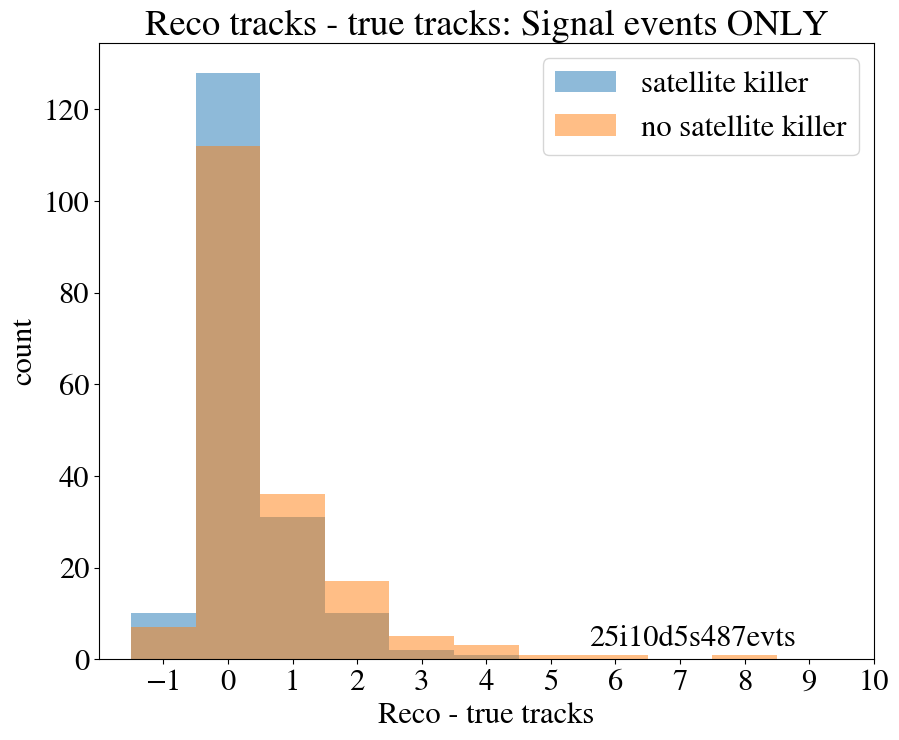

In [16]:
# FIX THE RANGES
q = np.array([a - b for a, b in zip(trk_num_sk, true_trk_no_sk)])
p = np.array([a - b for a, b in zip(trk_num_nsk, true_trk_no_nsk)])
f, ax = plt.subplots()
plt.hist(q, label = 'satellite killer', alpha = 0.5, bins=np.arange(-1,6)-0.5)
plt.hist(p, label = 'no satellite killer', alpha = 0.5, bins = np.arange(-1,10)-0.5)
plt.xticks(np.arange(-1, 11, 1.0))
plt.title('Reco tracks - true tracks: Signal events ONLY')
plt.xlabel('Reco - true tracks')
plt.text(.90, 0.01, identifier, ha = 'right', va = 'bottom', transform = ax.transAxes)
plt.legend()
#plt.yscale('log')
plt.ylabel('count')

In [17]:
# how many events do you gain/lose?
print("No. signal events w/ satkill passing 1-track cut")
print(len(q[q==0]))
print("No. signal events w/out satkill passing 1-track cut")
print(len(p[p==0]))

No. signal events w/ satkill passing 1-track cut
128
No. signal events w/out satkill passing 1-track cut
112


Event: 152
Number of true tracks: 2
Number of satkill tracks: 1
Number of non-satkill tracks: 1


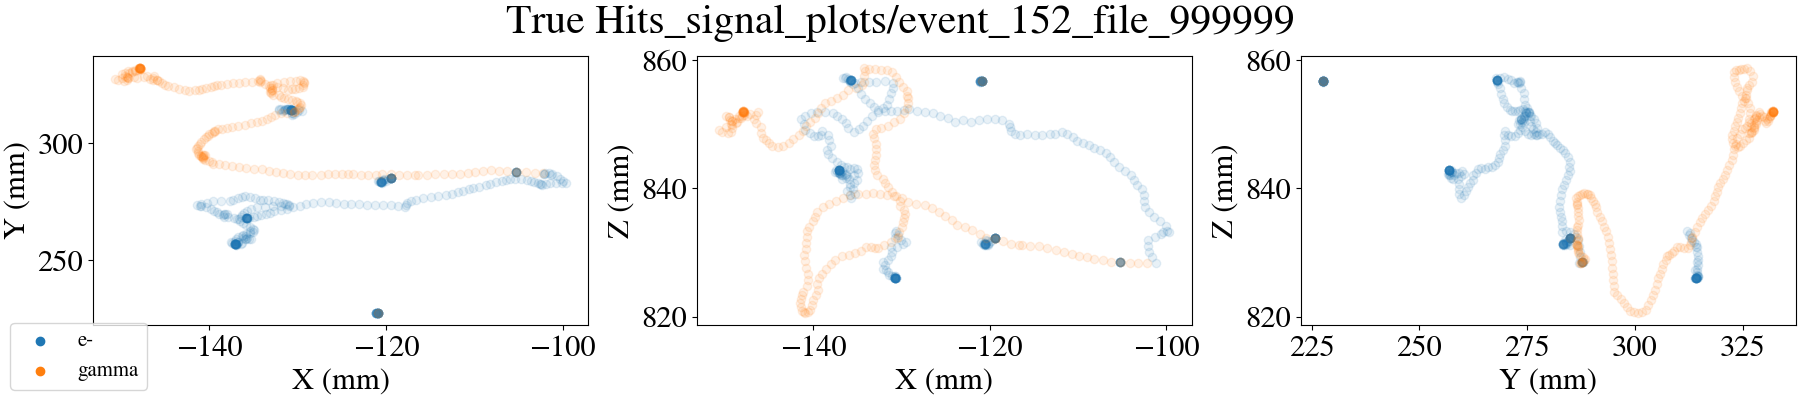

Event: 40530
Number of true tracks: 4
Number of satkill tracks: 3
Number of non-satkill tracks: 3


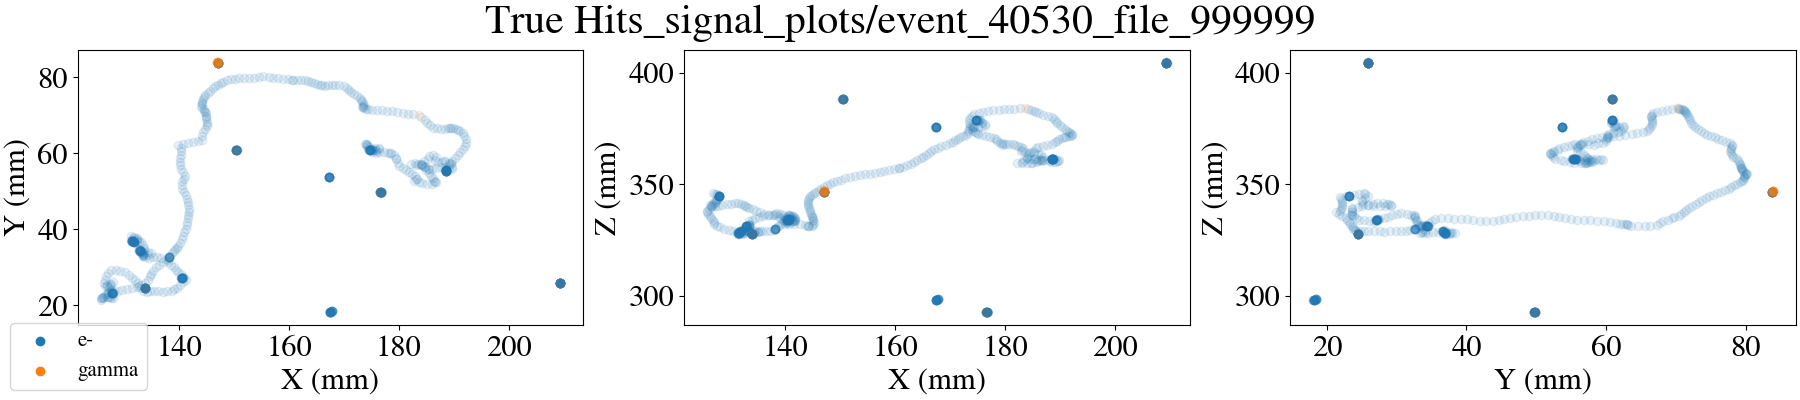

Event: 40556
Number of true tracks: 2
Number of satkill tracks: 1
Number of non-satkill tracks: 1


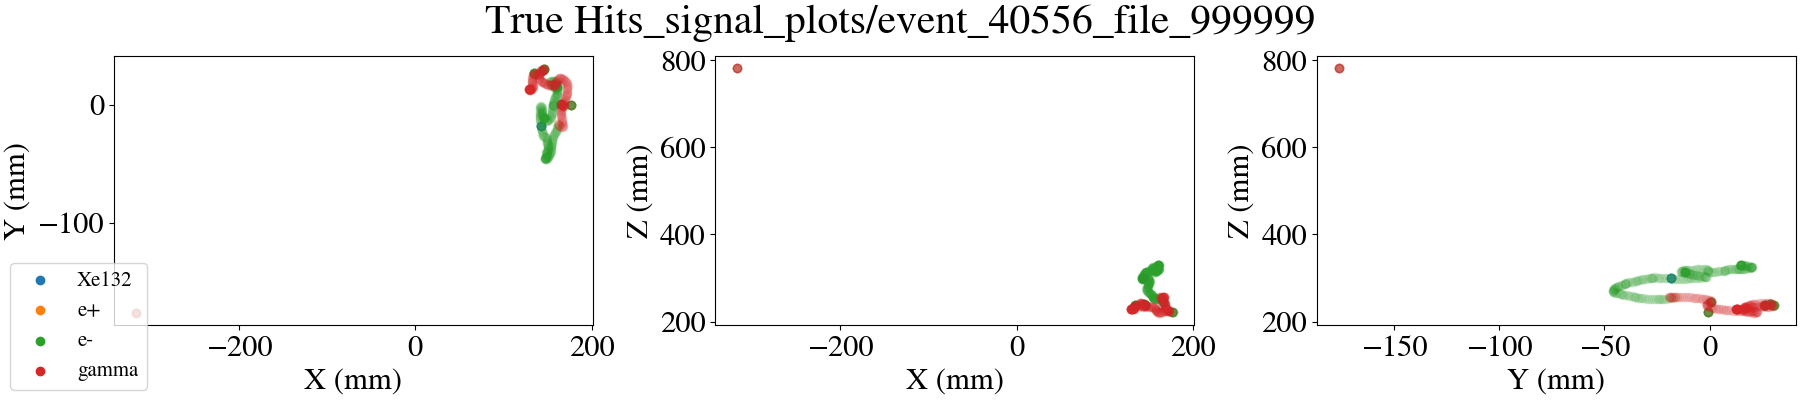

Event: 40694
Number of true tracks: 3
Number of satkill tracks: 2
Number of non-satkill tracks: 3


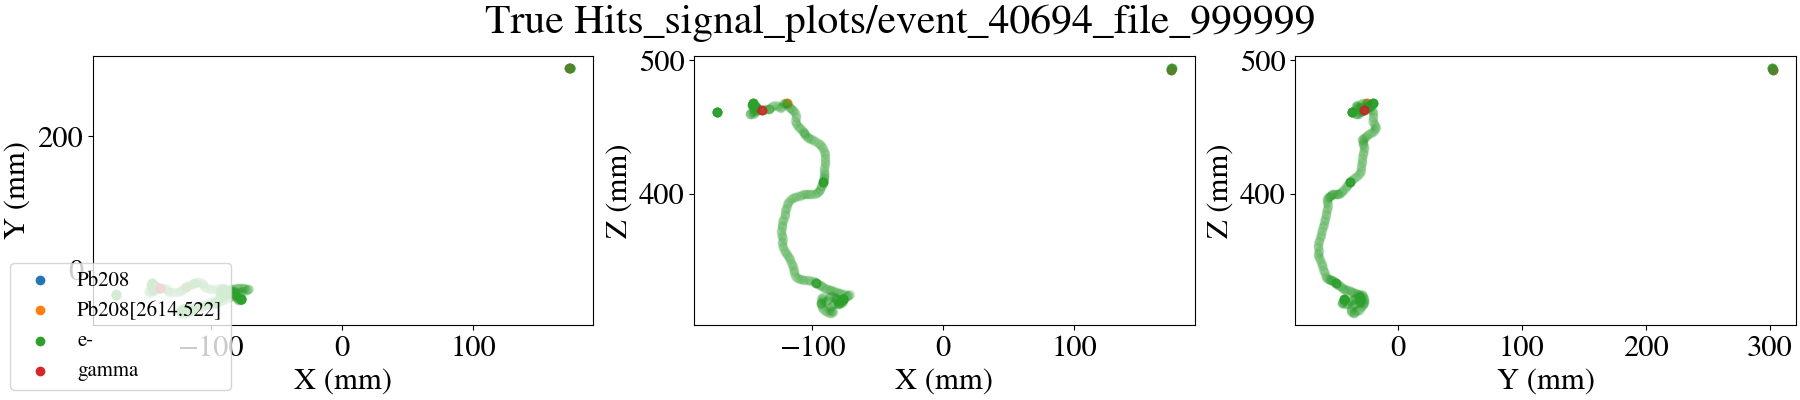

Event: 80038
Number of true tracks: 2
Number of satkill tracks: 1
Number of non-satkill tracks: 1


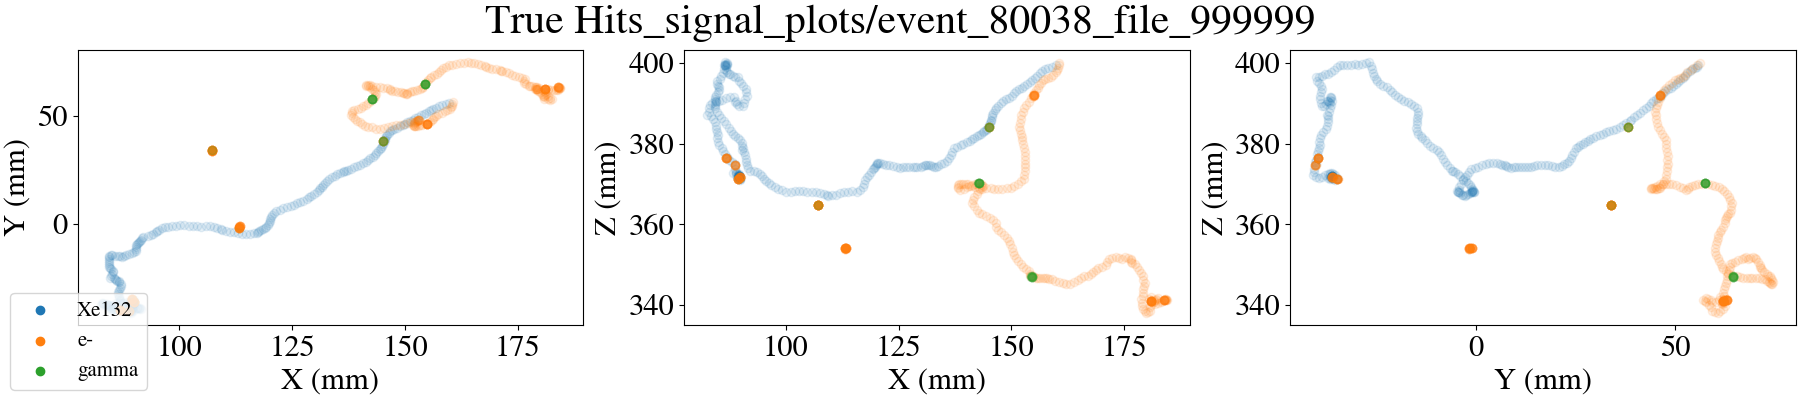

In [14]:
from IPython.display import Image

event_ids_nosat = list(event_id_nsk)
event_ids = list(event_id_sk)

file_no = 999999

for i in range(len(event_ids)):
    value_satkill = i
    test_true = true_trk_no_sk[value_satkill]
    try:
        test_true_nosat = event_ids_nosat.index(event_ids[value_satkill])
    except ValueError:
        #print("Event {} isn't in no-satkill".format(event_ids[value_satkill]))
        #print("")
        test_true_nosat = 0
    test_reco = trk_num_sk[value_satkill]
    test_reco_nosat = trk_num_nsk[test_true_nosat]
    
    if (q[i] == -1):
        print("Event: {}".format(event_ids[value_satkill]))
        print("Number of true tracks: {}".format(test_true))
        print("Number of satkill tracks: {}".format(test_reco))
        print("Number of non-satkill tracks: {}".format(test_reco_nosat))
        
        
        addr = 'signal_plots/event_' + str(event_ids[value_satkill]) + '_file_' + str(file_no) +  '/MC_true.png'
        display(Image(filename=addr))
    
    '''
    if (test_true ==1) and (test_reco == 1):
        print("Event: {}".format(event_ids[value_satkill]))
        #print("Event: {}".format(event_ids_nosat[test_true_nosat]))
        print("Number of true tracks: {}".format(test_true))
        print("Number of satkill tracks: {}".format(test_reco))
        print("Number of non-satkill tracks: {}".format(test_reco_nosat))

        print("")
        addr = 'signal_plots/event_' + str(event_ids[value_satkill]) + '_file_' + str(file_no) +  '/MC_true.png'
        display(Image(filename=addr))
    '''
    